# Yelp Reviews Sentiment Analysis EDA

This notebook explores the data created from the preprocessing notebook to see if there are common themes that emerge from positive and negative reviews. This will help determine whether a model can be built on this data.

## Data Importing and Initial Exploration

### Import the data

In [1]:
# Data handling and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from functools import reduce

In [2]:
# Import data and change data types
reviews = pd.read_csv("reviews_prep_v2.csv")
reviews = reviews.drop(['Unnamed: 0'], axis = 1)

# Define a function that will change the datatypes to desired ones
# The function will take a dictionary as input with keys as the column names and values as the desired datatype
def change_datatypes(df, **kwargs):
    for k, v in kwargs.items():
        if v == 'date':
            df[k] = pd.to_datetime(df[k]) #account for datetime conversions
        else:
            df[k] = df[k].astype(v)
    return df

# Define the types desired
type_conversions = {
    'date': 'date',
    'review': 'string',
    'title': 'string',
    'review_tokens': 'string',
    'review_POSes': 'string',
    'title_tokens': 'string',
    'title_POSes': 'string'
}

reviews = change_datatypes(reviews, **type_conversions)

# Confirm that the conversion was successful
reviews.dtypes

date              datetime64[ns]
review            string[python]
rating                     int64
title             string[python]
review_prepped            object
title_prepped             object
review_tokens     string[python]
review_POSes      string[python]
title_tokens      string[python]
title_POSes       string[python]
dtype: object

In [3]:
# View the first five rows of the dataframe
reviews.head(5)

,date,review,rating,title,review_prepped,title_prepped,review_tokens,review_POSes,title_tokens,title_POSes
0,2024-11-22 22:44:23,I say it can be fantastic because some people ...,5,Yelp can be fantastic,"['i/PRON', 'say/VERB', 'it/PRON', 'can/AUX', '...","['yelp/NOUN', 'can/AUX', 'be/AUX', 'fantastic/...",i say it can be fantastic because some people ...,PRON VERB PRON AUX AUX ADJ SCONJ DET NOUN VERB...,yelp can be fantastic,NOUN AUX AUX ADJ
1,2024-12-12 22:08:33,Yelp's developers have been spamming false 5-s...,1,Review botting should not be tolerated!,"['yelp/NOUN', 'developers/NOUN', 'have/AUX', '...","['review/NOUN', 'botting/NOUN', 'should/AUX', ...",yelp developers have been spamming false revie...,NOUN NOUN AUX AUX VERB ADJ NOUN ADP DET NOUN N...,review botting should not be tolerated,NOUN NOUN AUX PART AUX VERB
2,2024-10-11 18:43:56,I will not be using Yelp ever again. After a t...,1,Horrible,"['i/PRON', 'will/AUX', 'not/PART', 'be/AUX', '...",['horrible/ADJ'],i will not be using yelp ever again after a te...,PRON AUX PART AUX VERB NOUN ADV ADV ADP DET AD...,horrible,ADJ
3,2024-09-22 20:35:32,During think tank meetings with other business...,1,Is yelp fair?,"['during/ADP', 'think/NOUN', 'tank/NOUN', 'mee...","['is/AUX', 'yelp/NOUN', 'fair/ADJ']",during think tank meetings with other business...,ADP NOUN NOUN NOUN ADP ADJ NOUN NOUN ADP PRON ...,is yelp fair,AUX NOUN ADJ
4,2024-12-13 03:52:13,If I could give this place a 0 star I absolute...,1,Horrible service,"['if/SCONJ', 'i/PRON', 'could/AUX', 'give/VERB...","['horrible/ADJ', 'service/NOUN']",if i could give this place a star i absolutely...,SCONJ PRON AUX VERB DET NOUN DET NOUN PRON ADV...,horrible service,ADJ NOUN


### Word Cloud

A word cloud might be useful to understand what words are most frequently used in each review rating category

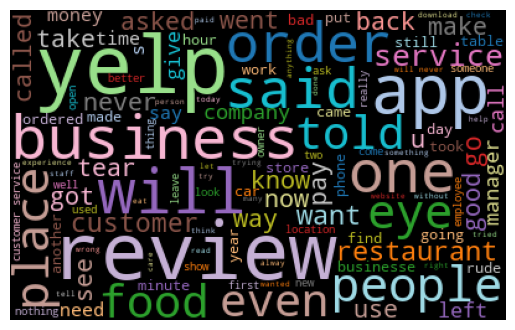

In [4]:
# Import the library
from wordcloud import WordCloud

# Create a word cloud where only ratings with a review of 1 star are included
all_reviews_1 = reviews[reviews['rating'] == 1]['review_tokens']
all_text_1 = ' '.join(word for word in all_reviews_1)
wordcloud = WordCloud(random_state = 1, width = 400, height = 250, max_font_size = 65, colormap = 'tab20').generate(all_text_1)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

From this word cloud, it seems that in one star reviews, people tend to talk about the business, reviews, calling, the food from a restaurant, or customer service.

### Most frequent words

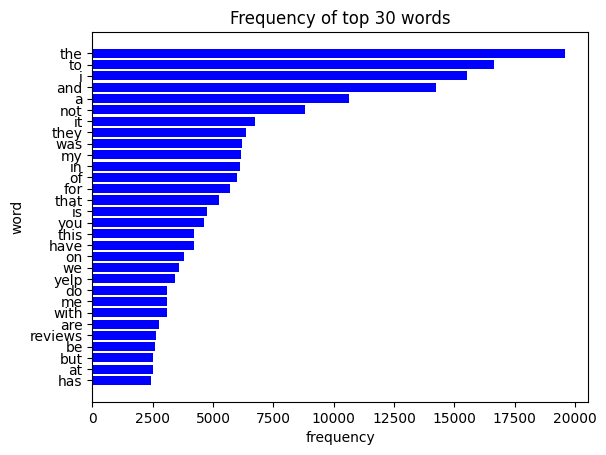

In [5]:
# Function that will calculate the top words that a user wants and give their frequency
def topwords(text, size):
    text_list = text.split(' ') # split the text into a list of words
    text_df = pd.DataFrame({'word': text_list, 'count': [1]*len(text_list)}) # each word is given an initial count of 1
    word_counts = text_df.groupby('word')['count'].agg('sum') # aggregate by word
    top_words = word_counts.sort_values(ascending = False)[0:size] # sort in descending order and take the top amount
    return top_words

# Get the frequency of the top 30 words
top_30_words_1 = topwords(all_text_1, 30)

# Visualize the data
fig = plt.figure()
x = top_30_words_1.index[::-1] # reverses the order the data is plotted, [start:stop:step]
y = top_30_words_1.values[::-1]
plt.barh(x, y, color = 'blue')
plt.ylabel('word')
plt.xlabel('frequency')
plt.title('Frequency of top 30 words')
plt.show()

These words have little semantic meaning behind them, so the machine might not be able to really interpret this in a bag of words dataset. Is there a way to find what words that are used in 1 star reviews that are not used in the other review categories?

## Finding words that are unique to each category

### Find unique words and their counts

Use the union - intersection formula (a XOR) to find the unique words in each category

In [6]:
# Example of behavior 
from functools import reduce

series1 = pd.Series([-1, 0, 0, 2])
series2 = pd.Series([-2, 0, 0, 3])

def findUnique(*args):
    union = reduce(np.union1d, args)
    intersect = reduce(np.intersect1d, args)
    shared = np.isin(union, intersect) # returns a boolean mask
    unique = ~shared # inverts the boolean mask

    series_unique = union[unique]
    return series_unique

# Expected output: [-2, -1, 2, 3]
print(findUnique(series1, series2))

[-2 -1  2  3]


In [7]:
# Using three or more series
series1 = pd.Series([-1, 1, 1, 0, 0, 2])
series2 = pd.Series([-2, 0, 0, 3])
series3 = pd.Series([-3, 0, 0, 4])

# Use unique function, expected output: [-3, -2, -1, 1, 2, 3, 4]
print(findUnique(series1, series2, series3))

[-3 -2 -1  1  2  3  4]


In [8]:
series3[series3.isin(findUnique(series1, series2, series3))]

0   -3
3    4
dtype: int64

Union will only return sorted unique values, it won't take into account value counts

In [9]:
# Create a function that filteres reviews and creates an array of texts
def segmentReviews(DataFrame, label_column, tokens_column, *ratings):

    # Create list of reviews, segmented by rating
    segmented_reviews = [DataFrame[DataFrame[label_column] == rating][tokens_column] for rating in ratings]
    
    # Create texts
    segmented_reviews_text = [str(' '.join(series)) for series in segmented_reviews]
    
    # Create token lists
    segmented_reviews_tokens = [text.split(' ') for text in segmented_reviews_text]
    
    # Create dataframes for each text
    segmented_reviews_all_dfs = [pd.DataFrame({'word': segment, 'count': [1]*len(segment)}) for segment in segmented_reviews_tokens]
    
    # Aggregate the word count for each text
    word_counts = [df.groupby(['word'])['count'].agg('sum') for df in segmented_reviews_all_dfs]
    
    # Perform XOR operation on all word count indices
    XOR_result = findUnique(*(df.index for df in word_counts))
    
    # Filter for words that are in the XOR result
    word_counts_unique = [word_count_df[word_count_df.index.isin(XOR_result)] for word_count_df in word_counts]
    
    # Sort the word counts
    word_counts_unique_sorted = [word_counts_df.sort_values(ascending = False) for word_counts_df in word_counts_unique]
    
    # Return all texts
    return word_counts_unique_sorted

all_reviews_1, all_reviews_2, all_reviews_3, all_reviews_4, all_reviews_5 = segmentReviews(reviews, 'rating', 'review_tokens', 1, 2, 3, 4, 5)

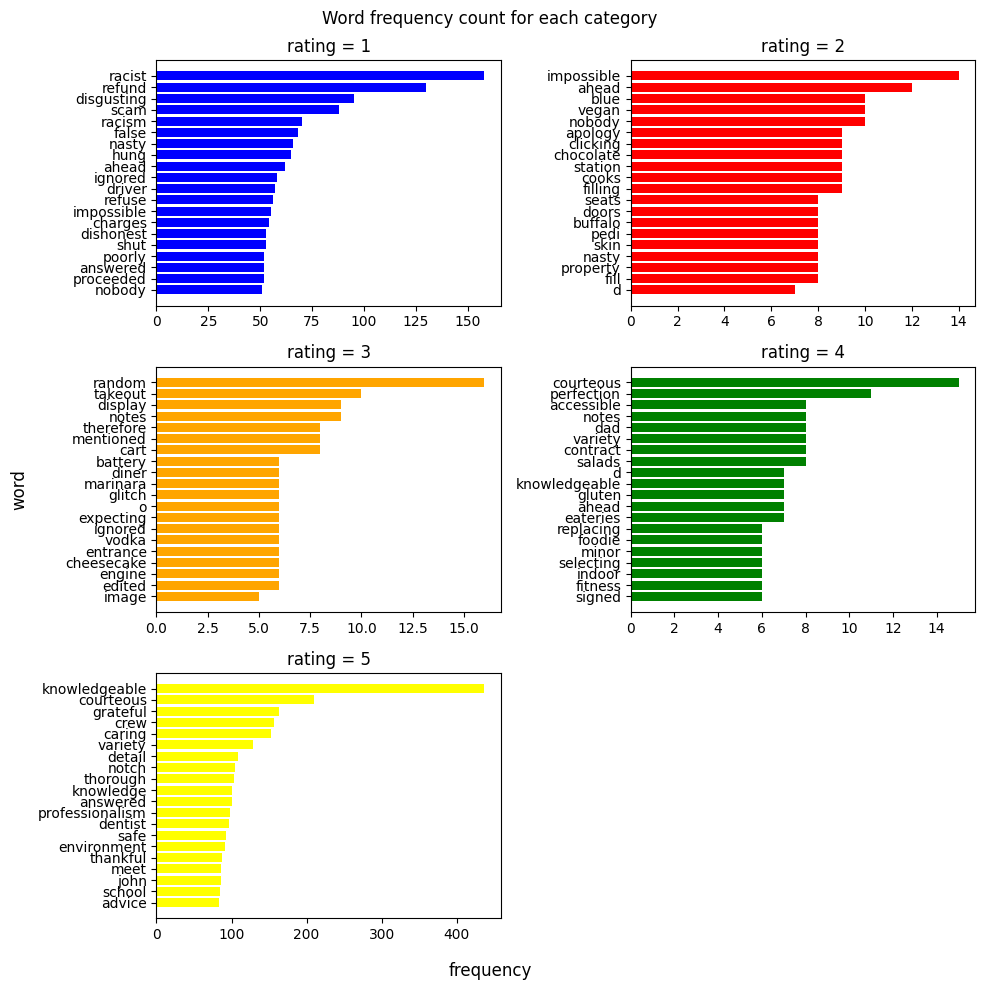

In [10]:
# Arragne and select the top 20 words and their frequencies for each category

# Define the reviews, colors, and titles that will be used for each
all_reviews = [all_reviews_1, all_reviews_2, all_reviews_3, all_reviews_4, all_reviews_5]
colors = ['blue', 'red', 'orange', 'green', 'yellow']
titles = ['rating = 1', 'rating = 2', 'rating = 3', 'rating = 4', 'rating = 5']

used_axes = [0, 1, 2, 3, 4]

# Plot
fig, ax = plt.subplots(3, 2, figsize = (10, 10))

for i, idx in enumerate(used_axes):
    ax.flat[idx].barh(all_reviews[i].index[19::-1], all_reviews[i][19::-1], color = colors[i])
    ax.flat[idx].set_title(titles[i])
    
ax.flat[5].axis('off')

fig.supxlabel('frequency')
fig.supylabel('word')
fig.suptitle('Word frequency count for each category')
plt.tight_layout()
plt.show()

Now that only the unique words for each category have been kept, we are starting to see some signal here. It is by no means a perfect visual, but it gives a starting point.

### Group the positive, neutral, and negative reviews together to see if more signal can be distinguished

In [11]:
def combineRatings(df, label_col, **new_labels):
    new_reviews = []
    # Use a loop to check what group each label belongs to, put in into a group, and then combine the groups
    for k, v in new_labels.items():
        df[label_col] = df[label_col].astype('string')
        if len(v) == 2:
            new_df = df[(df[label_col] == v[0]) | (df[label_col] == v[1])]
        else:
            new_df = df[df[label_col] == v[0]]
        new_df.loc[:, label_col] = k
        new_reviews.append(new_df)
    return pd.concat(new_reviews)

label_conversions = {'pos': ['5', '4'], 'neut': ['3'], 'neg': ['2', '1']}
reviews_compact = combineRatings(reviews, 'rating', **label_conversions)

reviews_positive, reviews_neutral, reviews_negative = segmentReviews(reviews_compact, 'rating', 'review_tokens', 'pos', 'neut', 'neg')

In [12]:
reviews_negative

word
racist          160
false            74
ahead            74
racism           71
hung             69
               ... 
incompetency      1
incompatible      1
incoming          1
inciting          1
îquagmire         1
Name: count, Length: 11789, dtype: int64

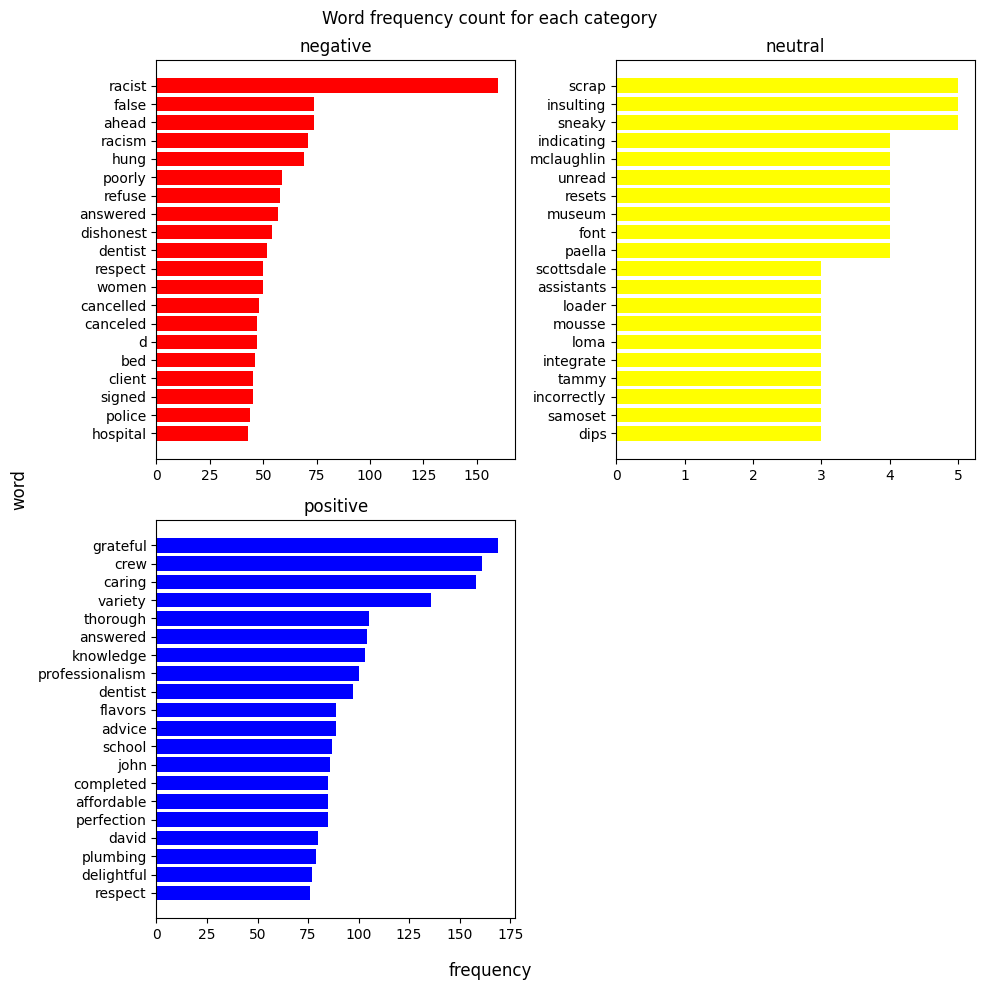

In [13]:
# Arrange and select the top 20 words and their frequencies for each category

# Define the reviews, colors, and titles that will be used for each
all_reviews = [reviews_negative, reviews_neutral, reviews_positive]
colors = ['red', 'yellow', 'blue']
titles = ['negative', 'neutral', 'positive']

used_axes = [0, 1, 2]

# Plot
fig, ax = plt.subplots(2, 2, figsize = (10, 10))

for i, idx in enumerate(used_axes):
    ax.flat[idx].barh(all_reviews[i].index[19::-1], all_reviews[i][19::-1], color = colors[i])
    ax.flat[idx].set_title(titles[i])
    
ax.flat[3].axis('off')

fig.supxlabel('frequency')
fig.supylabel('word')
fig.suptitle('Word frequency count for each category')
plt.tight_layout()
plt.show()

There is definitely more signal coming through now. The negative category shows words like racist and false over 100 times, and the positive category show words like caring over 100 times. The neutral category doesn't appear to have any unique words that stick out, the most of any unique one occuring 5 times. This gives promise that a model can be built from this, but it will likely be harder to detect the neutral sentiment since there aren't very many unique words there.

### See other words clouds

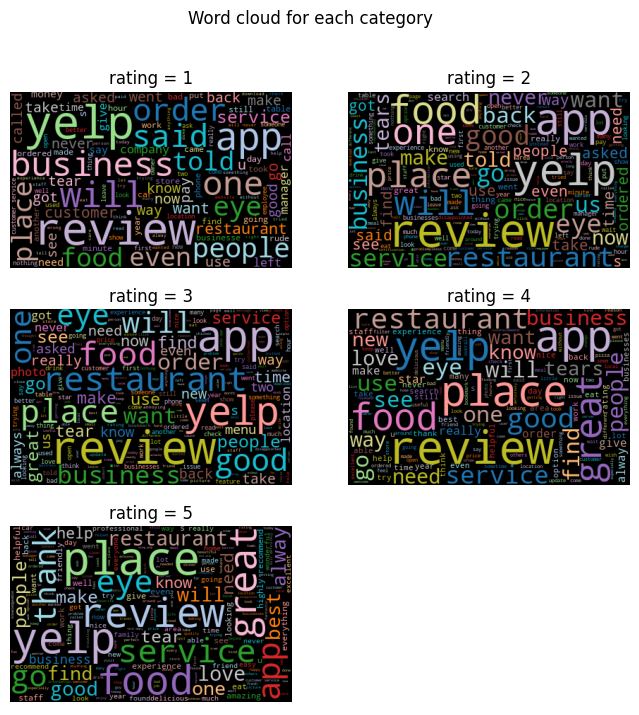

In [14]:
ratings_list = ['1', '2', '3', '4', '5']
fig, ax = plt.subplots(3, 2, figsize = (8, 8))

for i, rating in enumerate(ratings_list):
    all_reviews_rating = reviews[reviews['rating'] == rating]['review_tokens']
    all_text = ' '.join(word for word in all_reviews_rating)
    wc = WordCloud(random_state = 1, width = 400, height = 250, max_font_size = 65, colormap = 'tab20').generate(all_text)
    ax.flat[i].imshow(wc)
    ax.flat[i].set_title(f"rating = {rating}")
    ax.flat[i].axis('off')

ax.flat[5].axis('off')
fig.suptitle('Word cloud for each category')
plt.show()

The word clouds have a lot of similar words between them including yelp, review, restaurant, place, service, and business. These are certain stop words that seem to be clouding the signal. This means that everyone talks about these aspects, but how they talk about it is unknown.

### Removing corpus specific stop words

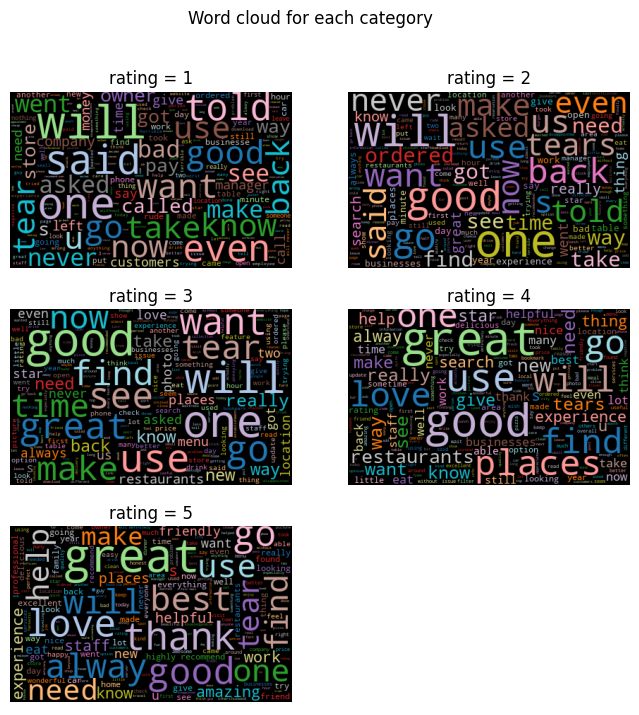

In [15]:
from wordcloud import STOPWORDS
my_stopwords = set(STOPWORDS)
yelp_stopwords = [
    'yelp', 
    'review', 
    'restaurant', 
    'place', 
    'business', 
    'reviews', 
    'app', 
    'food',
    'customer',
    'service', 
    'people', 
    'order',
    'eye',
    'eyes'
]
my_stopwords.update(yelp_stopwords)

ratings_list = ['1', '2', '3', '4', '5']
fig, ax = plt.subplots(3, 2, figsize = (8, 8))

for i, rating in enumerate(ratings_list):
    all_reviews_rating = reviews[reviews['rating'] == rating]['review_tokens']
    all_text = ' '.join(word for word in all_reviews_rating)
    wc = WordCloud(
        random_state = 1, 
        width = 400, 
        height = 250, 
        max_font_size = 65,
        stopwords = my_stopwords,
        colormap = 'tab20').generate(all_text)
    ax.flat[i].imshow(wc)
    ax.flat[i].set_title(f"rating = {rating}")
    ax.flat[i].axis('off')

ax.flat[5].axis('off')
fig.suptitle('Word cloud for each category')
plt.show()

From these word clouds with the specific stop words removed there seems to be some clear signal emerging from the five star ratings. From assumption, the one and two star ratings seem to be mostly concerned with being misled or not being followed up with. 

## Exploring reviews that mention certain keywords

Let's see what some of these words are pointing to in each review category

In [16]:
for review in reviews[reviews['rating'] == '1']['review']:
    if re.search("will", review):
        print(review)
        break

I will not be using Yelp ever again. After a terrible encounter with a business, I wrote an honest review about my experience. Yelp deleted 3 of my accounts because they would not let me write my review due to the business owner being upset. If I’m not able to be honest about good and bad experiences then what’s the point? Customer service did nothing to help the problem and all of the positive reviews I had wrote for small businesses were also deleted with my accounts. Such a shame. I thought as an app that is centered around honest reviews, they would uphold their end of allowing them, but no, they will side with businesses and delete your Yelp account for using the app as it was intended. Absolutely disgusting. I have moved onto other apps/platforms that respect their user’s honesty and do not punish them for reviews. If a business scams people out of their money, I believe it’s my responsibility to inform people through a public review, so that someone else isn’t a victim to it, bu

In [17]:
for review in reviews[reviews['rating'] == '2']['review']:
    if re.search("one", review):
        print(review)
        break

Be very cautious about taking your car to ACE automotive on Railroad Ave Santa Clarita. I have used them for years but now their quality and integrity seems to be in question. I spent $500 for six spark plugs and one ignition coil earlier in the week. One ignition coil had failed at 88,000 miles yet they felt they only had to place one. Statistical reliability says if one out of six failed at 88,000 miles another failure is just around the corner.  Two days later after picking up the car the transmission shifting cable broke. Parkway Cadillac/ GMC says that the cable should last 150K to 175K miles. When that cable broke the car was inoperable and was towed back to ACE were they again charged $440 to replace the cable. The Internet says it should only cost $260 to replace, parts and labor.
Skeptical billing have been made by other friends. Just be careful if you continue to use ACE automotive. especially if something goes wrong with your automobile a couple days after you pick it up.


In [18]:
for review in reviews[reviews['rating'] == '3']['review']:
    if re.search("time", review):
        print(review)
        break

I love Yelp and use it constantly, posting reviews, searching restaurants and businesses, and engaging with content and other users. However, 9 times out of 10, the photos I upload with my reviews do not get attached with my review. They’ll show up in the photo stream, but not along with my review. I would have to re-upload multiple times for it to work, or delete the photos and re-upload, but just as often it doesn’t work anyway. It’s extremely frustrating and makes me hold back posting reviews more frequently because of how much time it takes to deal with this problem. A Google search shows that this has been an ongoing issue for YEARS!!! Developers please find a way to fix it! It discourages users from posting on the platform more often and as you’re a crowd-sourced content platform, I would think this problem merits priority.


In [19]:
for review in reviews[reviews['rating'] == '4']['review']:
    if re.search("great", review):
        print(review)
        break

A great place a great time. Staff was great. People are friendly and food was excellent.. Would I have a venue there again? Yes I would consider it. The only thing is that when it comes to the food that you pay for make sure you have a understanding with the staff about what is done with it after you eat. Because we could’ve had seconds or people could’ve gone up for more food app, and the food will serve. I understand that they can’t have the food out for a certain period of time but they still should let the customers know. Hey we’re about to put the food up do you want more food? But instead of doing that they said the food was already thrown out, skeptical on that remark but overall a great time a great place


In [20]:
for review in reviews[reviews['rating'] == '5']['review']:
    if re.search("love", review):
        print(review)
        break

The Yelp app has become a must-have on my phone. Whether I’m looking for a great new restaurant, a local service, or even hidden gems in a city I’m visiting, Yelp has it all. The app makes it easy to browse reviews from real people, and I find that the ratings are consistently accurate and reliable.

One of my favorite features is the search filter. I can narrow down options based on location, price, and even specific amenities, which saves a lot of time. Plus, the photos uploaded by users give an honest look at what to expect, especially for restaurants.

I also love the ability to bookmark places. When friends recommend spots or I find something that looks interesting, I can save it for later. It’s been a lifesaver when I’m out and need a last-minute recommendation!

The community vibe on Yelp is awesome. The detailed reviews and tips from others help me make informed decisions, and I appreciate the transparency in feedback—both the good and the not-so-good. It feels like having a ne

One of the things I notice is that people don't always talk about their experience with Yelp, instead they only post their experience about a certain place. However, people tend to use similar language when they write a bad review, versus a good review.